# 1- Cabecera

## 1.1 Imports

In [1]:
# numeric and matrix operations
import numpy as np
import pandas as pd

# operating system
import os

import datetime
#from datetime import datetime, timedelta, date

# loading ploting libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# silence warnings
import warnings
warnings.filterwarnings("ignore")

from pathlib import Path

# python core library for machine learning and data science
import sklearn
from sklearn import set_config
set_config(transform_output = "pandas")

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller


pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows', 100)

## 1.2 Incialización

In [2]:
if pd.__version__ != "2.2.1":
    os.system("pip install pandas==2.2.1")
direccion = 'data/'

## 1.3 Carga fichero de datos primera étapa

In [3]:
if 'df' in globals() or 'df' in locals():
    del df

In [4]:
if 'df' in globals() or 'df' in locals():
    print("df existe")
else:
    print("df no existe")    
    df = pd.read_csv(direccion+"tabladia_vf.csv")
df["date"]=pd.to_datetime(df["date"])

df no existe


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59181090 entries, 0 to 59181089
Data columns (total 13 columns):
 #   Column      Dtype         
---  ------      -----         
 0   id          object        
 1   item        int64         
 2   category    int64         
 3   department  int64         
 4   store_code  int64         
 5   region      int64         
 6   d           object        
 7   Cantidad    int64         
 8   date        datetime64[ns]
 9   event2      int64         
 10  event       int64         
 11  yearweek    int64         
 12  sell_price  float64       
dtypes: datetime64[ns](1), float64(1), int64(9), object(2)
memory usage: 5.7+ GB


### 1.3 Borramos los campos que no vamos a usar y que estan orientados a la predicción

In [6]:
del df['d']
del df['event2']

## 1.4 Funciones

### 1.4.1 Eventos

In [8]:
def dia_accion_gracias(year):
    '''
    También sirve para el Black Friday, es un dia después
     Se asume que el Día de Acción de Gracias es el cuarto jueves de noviembre
    Se determina el primer día de noviembre
    '''
    primer_noviembre = datetime.date(year, 11, 1)
    # Se obtiene el día de la semana del primer día de noviembre (0: lunes, 1: martes, ..., 6: domingo)
    dia_semana_primer_noviembre = primer_noviembre.weekday()
    # Se calcula la cantidad de días que hay que sumar para llegar al cuarto jueves
    dias_hasta_jueves = (3 - dia_semana_primer_noviembre + 7) % 7
    # Se suma la cantidad de días al primer día de noviembre
    cuarto_jueves_noviembre = primer_noviembre + datetime.timedelta(days=dias_hasta_jueves + 21)
    return cuarto_jueves_noviembre

def dia_de_la_madre(year):
    ''' 
    Se establece la fecha del segundo domingo de mayo
    '''
    segundo_domingo_mayo = datetime.date(year, 5, 1) + datetime.timedelta(days=(6 - datetime.date(year, 5, 1).weekday()) + 7)
    return segundo_domingo_mayo

def dia_del_padre(year):
    '''
    Se establece la fecha del tercer domingo de junio
    '''
    tercer_domingo_junio = datetime.date(year, 6, 1) + datetime.timedelta(days=(6 - datetime.date(year, 6, 1).weekday()) + 7*2)
    return tercer_domingo_junio

def dia_del_presidente(year):
    '''
    Se establece la fecha del tercer lunes de febrero
    '''
    tercer_lunes_febrero = datetime.date(year, 2, 1) + datetime.timedelta(days=(0 - datetime.date(year, 2, 1).weekday()) + 7*2)
    return tercer_lunes_febrero

def labor_day(year):
    '''
     Se establece la fecha del primer lunes de septiembre
    '''
    primer_lunes_septiembre = datetime.date(year, 9, 1)
    if primer_lunes_septiembre.weekday() != 0:  # Si el 1 de septiembre no es lunes, avanzamos al próximo lunes
        primer_lunes_septiembre += datetime.timedelta(days=(0 - primer_lunes_septiembre.weekday()) % 7)
    return primer_lunes_septiembre

def black_friday_date(year):
    black_friday = dia_accion_gracias(year) + datetime.timedelta(days=1)
    return black_friday

def dias_anteriores(dia=datetime.date(2000, 12, 25),dias=14):
    fecha_anterior = dia - datetime.timedelta(days=dias)
    dias_anteriores = [fecha_anterior + datetime.timedelta(days=i) for i in range(dias)]
    return dias_anteriores

### 1.4.2 Tendencia

In [10]:
def calcular_tendencia(df_item):
    '''
    Regresion Lineal del dataframe de compras por tienda
    Puebla tendencia con en los dos dataframes sí
    1 - Si pendiente es mayor de 0.005
    0 - Si la pendiente está entre 0.005 y -0.005
    -1 - Si la pendiente es menor de -0.005
    '''
    df_item['cantidad_por_mes'] = df_item.groupby(df_item['primer_dia_mes'].dt.to_period('M'))['Cantidad'].transform('sum')
    X = np.arange(1, len(df_item) + 1).reshape(-1, 1)
    y = df_item["cantidad_por_mes"].values
    modelo = LinearRegression()
    modelo.fit(X, y)
    # Obtener la pendiente (tendencia)
    pendiente = modelo.coef_[0]
    if pendiente >= 0.005:
        #df.loc[df_item.index, 'tendencia'] = 1
        df_con_cantidad.loc[df_item.index, 'tendencia'] = 1
    elif pendiente < 0.005 and pendiente > -0.005:
        #df.loc[df_item.index, 'tendencia'] = 0
        df_con_cantidad.loc[df_item.index, 'tendencia'] = 0
    else:
        #df.loc[df_item.index, 'tendencia'] = -1
        df_con_cantidad.loc[df_item.index, 'tendencia'] = -1
    
    print("Item", df_item['item'].iloc[0], "Tendencia:", pendiente)

### 1.4.3 Estacionalidad

In [11]:
def calcular_p_estacionalidad(df_item):

    #df_item = df_item[df_item["item"]==2829]
    # Iterar sobre cada producto único en el DataFrame
    for producto in df_item['item'].unique():
        # Seleccionar las ventas correspondientes a un producto específico
        ventas_producto = df_item.loc[df_item['item'] == producto, 'Cantidad']

        #indices
        #indices1= df[(df['item'] == producto)].index.tolist()
        indices2= df_con_cantidad[(df_con_cantidad['item'] == producto)].index.tolist()
        
        #print(len(ventas_producto))
        #vemos si ha suficientes valores en la serie para comprobar la estacionaalidad
        if len(ventas_producto)>= 10:
             # Realizar la prueba de Dickey-Fuller aumentada para las ventas del producto
            result = adfuller(ventas_producto)
        else:
            #suponemos que la serie no es estacional y seguimos al sigueinte producto/tienda
            #df.loc[indices1, 'estacionalidad'] = 0
            df_con_cantidad.loc[indices2, 'estacionalidad'] = 0
            print("No hay suficientes datos en la serie para el producto: ", producto)
            continue
        
        # Extraer el valor p de la prueba
        p_value = result[1]

        # Imprimir el resultado para el producto actual
        print("Grado de estacionalidad para el producto", producto, "es", p_value, "con coeficiente ADF:", result[0])
        if p_value <= 0.05:
            #df.loc[indices1, 'estacionalidad'] = 1
            df_con_cantidad.loc[indices2, 'estacionalidad'] = 1

        else:
            #df.loc[indices1, 'estacionalidad'] = 0
            df_con_cantidad.loc[indices2, 'estacionalidad'] = 0

### 1.4.4 KNN

In [12]:
def dibujar_curva_codo (df_final):
    '''
    Dibujo del codo Kmeans para encontrar el número de cluster mejor
    '''
    # separamos el pipeline del a loop, para no tener que volver a hacer los primeros 3 pasos para cada k de la loop
    pipe = Pipeline(steps = [
        #quitamos los nulos con el KNNImputer
        ("Imputer", KNNImputer()),
        #Descartamos autlayers
        ("RobustScaler", RobustScaler(quantile_range = (0, 99.0)))
    ])
    df_scaled_transformed = pipe.fit_transform(df_final)
    sse = {}
    for k in range(2, 15):

        #print(f"Fitting pipe with {k} clusters")

        clustering_model = KMeans(n_clusters = k)
        clustering_model.fit(df_scaled_transformed)

        sse[k] = clustering_model.inertia_
    fig = plt.figure(figsize = (16, 8))
    ax = fig.add_subplot()

    x_values = list(sse.keys())
    y_values = list(sse.values())

    ax.plot(x_values, y_values, label = "Inercia/dispersión de los clústers")
    fig.suptitle("Variación de la dispersión de los clústers en función de la k", fontsize = 16)


def dibujar_cluster(df_final_cluster,grupos):
    '''    
    Devolvemos una tabla de estadísticas para decidir lso clusters 
            '''
    pipe = Pipeline(steps = [
        ("Imputer", KNNImputer()),
        ("RobustScaler", RobustScaler(quantile_range = (0, 99.0))),
        ("Clustering", KMeans(n_clusters = grupos, random_state = 175))
    ])

    pipe.fit(df_final_cluster)
    model = pipe[-1]
    model.cluster_centers_.shape
    X_processed = pipe[:1].transform(df_final_cluster)
    labels = pipe.predict(df_final_cluster)
    X_processed["cluster"] = labels
    pd.set_option('display.max_rows', None)
    Clusters=X_processed.groupby(["cluster"]).describe().loc[:,(slice(None),['mean'])].T
    Contadores=X_processed.groupby(["cluster"]).describe().loc[:,(slice(None),['count'])].T.iloc[[0]]
    Clusters=pd.concat([Contadores,Clusters], axis=0)
    return Clusters, X_processed


def generate_multiindex(list_of_tuples, names):
    return pd.MultiIndex.from_tuples(list_of_tuples, names = names)


def montar_tabla_cluster(ficha_df,X_processed):
    lc=ficha_df.columns.to_list()
    ficha_df = pd.DataFrame()
    for i, col in enumerate(lc):
        resumen_data = X_processed[["cluster", col]].groupby("cluster").describe().T.iloc[1:][:1]
        ficha_df=pd.concat([ficha_df,resumen_data])
    # generamos nuestro multiindex
    out_index = [
        "Ventas",
        "Precios",
        "Precios",
        "Ingresos",
        "Repetitividad",
        "Tendencia",
        "Estacionalidad",
        "Eventos"
    ]

    inner_index = [
        "Vendidos",
        "Precio mínimo",
        "Precio máximo",
        "Ingresos",
        "Días entre ventas",
        "Tendencia",
        "Estacionalidad",
        "Eventos"
    ]

    names = ["Grupo Indicadores", "Indicador", "Estadístico"]

    estadisticos=["Media"]

    new_multi_index = []

    for oi, ii, in zip(out_index, inner_index):
        for es in estadisticos:
            new_multi_index.append((oi, ii, es))
    
    index_ficha = generate_multiindex(new_multi_index, names)
    ficha_df.set_index(index_ficha, inplace = True)
    tamaño_clusters = X_processed.groupby("cluster").size().to_frame().T
    tamaño_clusters.set_index(generate_multiindex([("General", "Clúster", "Tamaño")] , names), inplace = True)
    ficha_df = pd.concat([tamaño_clusters,ficha_df], ignore_index=False)
    return ficha_df

# 2 Calculos de Columnas

## 2.1 Eventos

Cálculos de días especiales de compras o regalos
Los datos de Eventos que me vienen en el origen (excepto el día de acción de gracias) no son muy relevantes para el dia de compras, el inicio del ramadán, la super bowl o el viernes santo o el primer dia del año no son fechas que se caractericen por una aumento de compras en EE.UU., en cambio, Navidad, San Valentín el día del padre o de la madre, o el black fryday sí. Vamos a borrar los datos y a recalcular y asignar pesos a los días que preceden a la festividad.

-Para el periodo de Navidad asignaremos un periodo de 2 semanas con un peso de 3
-Para el dia de blackfryday asignamos ese día con peso 3
-Para San Valentin asignamos 7 dias antes con peso 2
-Para el dia de acción de gracias asignamos una semana con peso de 2
-Para el dia de la madre una semana con peso 2
-Para el dia del padre una semana con peso 2
-Para el dia del presidente 3 dias antes con peso 2
-Para el dia del trabajo 3 dias anteriores con peso 2

El resto de días tendrán valor 1

### 2.1.1 Reseteamos valores

In [13]:
df['event'] = 0

In [14]:
#buscamos los años del dataset
annos=df['date'].dt.year.unique()

### 2.1.2 Navidad

In [15]:
fechas_anteriores_navidad = pd.Series([])
for y in annos:
    dia = datetime.date(y, 12, 25)
    fechas_anteriores_navidad = pd.Series(list(fechas_anteriores_navidad)+dias_anteriores(dia,14))
df.loc[df['date'].isin(fechas_anteriores_navidad),'event'] = 3

### 2.1.3 Blackfriday

In [16]:
blackfridays = pd.Series([])
for y in annos:
    dia = black_friday_date(y)
    blackfridays = pd.Series(np.append(list(blackfridays),dia))
df.loc[df['date'].isin(blackfridays),'event'] = 3

### 2.1.4 San Valentín

In [17]:
sanvalentindays = pd.Series([])
for y in annos:
    dia = datetime.date(y, 2, 14)
    sanvalentindays = pd.Series(list(sanvalentindays)+dias_anteriores(dia,7))
df.loc[df['date'].isin(sanvalentindays),'event'] = 2

### 2.1.5 Acción de gracias

In [18]:
thanksgiving = pd.Series([])
for y in annos:
    dia = dia_accion_gracias(y)
    thanksgiving = pd.Series(list(thanksgiving)+ dias_anteriores(dia,7))
df.loc[df['date'].isin(thanksgiving),'event'] = 2

### 2.1.6 Dia de la madre

In [19]:
mothersday = pd.Series([])
for y in annos:
    dia=dia_de_la_madre(y)
    mothersday = pd.Series(list(mothersday)+ dias_anteriores(dia,7))
df.loc[df['date'].isin(mothersday),'event'] = 2

### 2.1.7 Dia del Padre

In [20]:
fathersday = pd.Series([])
for y in annos:
    dia=dia_del_padre(y)
    fathersday = pd.Series(list(fathersday)+dias_anteriores(dia,7))
df.loc[df['date'].isin(fathersday),'event'] = 2

### 2.1.8 Dia del presidente

In [21]:
presidentsday = pd.Series([])
for y in annos:
    dia = dia_del_presidente(y)
    presidentsday = pd.Series(list(presidentsday)+dias_anteriores(dia,3))
df.loc[df['date'].isin(presidentsday),'event'] = 2

### 2.1.9 Dia del trabajo

In [22]:
diatrabajo = pd.Series([])
for y in annos:
    dia = labor_day(y)
    diatrabajo = pd.Series(list(diatrabajo)+dias_anteriores(dia,3))
df.loc[df['date'].isin(diatrabajo),'event'] = 2

In [23]:
df['event']=df['event'].replace(0,1)

## 2.2 Calculamos ingresos

In [24]:
df["income"]=df["Cantidad"]*df["sell_price"]

In [25]:
df['primer_dia_mes'] = df['date'].dt.to_period('M').dt.start_time

In [26]:
df['tendencia'] = np.nan

In [27]:
df['estacionalidad'] = np.nan

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59181090 entries, 0 to 59181089
Data columns (total 15 columns):
 #   Column          Dtype         
---  ------          -----         
 0   id              object        
 1   item            int64         
 2   category        int64         
 3   department      int64         
 4   store_code      int64         
 5   region          int64         
 6   Cantidad        int64         
 7   date            datetime64[ns]
 8   event           int64         
 9   yearweek        int64         
 10  sell_price      float64       
 11  income          float64       
 12  primer_dia_mes  datetime64[ns]
 13  tendencia       float64       
 14  estacionalidad  float64       
dtypes: datetime64[ns](2), float64(4), int64(8), object(1)
memory usage: 6.6+ GB


## 2.3 Creación dataframe sin compras 0

A partir de este momento vamos a trabajar con un dataframe sin los días en que las compras fueran 0 para poder tener unos cálculos de estacionalidad, tendencia más acusados y agregados más acusados.

In [29]:
#creamos un dataframe con solo ventas
df_con_cantidad = df[df["Cantidad"] != 0]
df_con_cantidad.head()

,id,item,category,department,store_code,region,Cantidad,date,event,yearweek,sell_price,income,primer_dia_mes,tendencia,estacionalidad
899,ACCESORIES_1_001_BOS_1,0,0,0,0,0,1,2013-07-16,1,201329,10.9858,10.9858,2013-07-01,NaN,NaN
900,ACCESORIES_1_001_BOS_1,0,0,0,0,0,3,2013-07-17,1,201329,10.9858,32.9574,2013-07-01,NaN,NaN
909,ACCESORIES_1_001_BOS_1,0,0,0,0,0,3,2013-07-26,1,201330,10.9858,32.9574,2013-07-01,NaN,NaN
910,ACCESORIES_1_001_BOS_1,0,0,0,0,0,1,2013-07-27,1,201330,10.9858,10.9858,2013-07-01,NaN,NaN
912,ACCESORIES_1_001_BOS_1,0,0,0,0,0,2,2013-07-29,1,201331,10.9858,21.9716,2013-07-01,NaN,NaN


### 2.3.1 Verificamos la última fecha de compras para poder tratar descontinuados.

In [30]:
#Última compra
df_con_cantidad['date'].max()

Timestamp('2016-04-24 00:00:00')

In [31]:
#creamos df de ultima compra por item
ultima_fecha_venta = df_con_cantidad.groupby('item')['date'].max().reset_index()
ultima_fecha_venta.head()

,item,date
0,0,2016-04-24
1,1,2016-04-24
2,2,2016-04-24
3,3,2016-04-24
4,4,2016-04-24


In [32]:
# Filtramos productos que no se han vendido después de la fecha de corte
productos_no_vendidos = ultima_fecha_venta[ultima_fecha_venta['date'] <= pd.to_datetime('2015-04-24')]
productos_no_vendidos

,item,date
326,326,2015-01-27


Vemos que solo hay un producto que no se vende un año antes de la venta del último, consideramos despreciable la influencia en el cluster

## 2.4 Cálculo de la tendencia

In [33]:
if df_con_cantidad[df_con_cantidad["tendencia"].isnull()]["item"].nunique() > 0:
    df_con_cantidad[df_con_cantidad['tendencia'].isnull()].groupby("item").apply(calcular_tendencia)

Item 0 Tendencia: 0.0032654306926302073
Item 1 Tendencia: -0.0009763259897079123
Item 2 Tendencia: 0.0033406022435366486
Item 3 Tendencia: -4.858895519439626e-05
Item 4 Tendencia: 0.0012947849244297938
Item 5 Tendencia: -0.0057868082313936005
Item 6 Tendencia: 0.0025988041988183465
Item 7 Tendencia: -0.004279908137750924
Item 8 Tendencia: -0.0019522682625286523
Item 9 Tendencia: -0.0007110404598621992
Item 10 Tendencia: 0.0008469032216086331
Item 11 Tendencia: -0.003358508733162522
Item 12 Tendencia: -0.0004159236474333939
Item 13 Tendencia: 0.006499072718323073
Item 14 Tendencia: -0.004441031379818833
Item 15 Tendencia: -0.0014976739068674164
Item 16 Tendencia: -0.0033595267619203604
Item 17 Tendencia: 0.0006814814658821274
Item 18 Tendencia: -0.0067623717249701235
Item 19 Tendencia: -0.00034556219769801643
Item 20 Tendencia: -0.003458051862040053
Item 21 Tendencia: -0.0012297782724953181
Item 22 Tendencia: -0.007274224610235682
Item 23 Tendencia: 0.0005347799198929446
Item 24 Tendenc

## 2.5 Cálculo de la estacionalidad

In [34]:
df_con_cantidad_M=df_con_cantidad.set_index("primer_dia_mes").groupby("item").resample("M")[["Cantidad","estacionalidad"]].apply("sum").reset_index()
df_con_cantidad_M.head()

,item,primer_dia_mes,Cantidad,estacionalidad
0,0,2013-07-31,27,0.0
1,0,2013-08-31,88,0.0
2,0,2013-09-30,94,0.0
3,0,2013-10-31,117,0.0
4,0,2013-11-30,136,0.0


In [35]:
if (len(df["estacionalidad"].isnull()) > 0):
    calcular_p_estacionalidad(df_con_cantidad_M)

Grado de estacionalidad para el producto 0 es 0.7070316406620836 con coeficiente ADF: -1.1199974243774
Grado de estacionalidad para el producto 1 es 0.6760108168910219 con coeficiente ADF: -1.1943748485723085
Grado de estacionalidad para el producto 2 es 0.036484127814364255 con coeficiente ADF: -2.9832953466308494
Grado de estacionalidad para el producto 3 es 0.04277630315167258 con coeficiente ADF: -2.922654476468727
Grado de estacionalidad para el producto 4 es 0.022531659627967233 con coeficiente ADF: -3.1582573557364033
Grado de estacionalidad para el producto 5 es 0.04110529979550035 con coeficiente ADF: -2.937989849468152
Grado de estacionalidad para el producto 6 es 0.05208784481257187 con coeficiente ADF: -2.845306203608701
Grado de estacionalidad para el producto 7 es 0.011730883312777796 con coeficiente ADF: -3.378033791595298
Grado de estacionalidad para el producto 8 es 0.21524752743869519 con coeficiente ADF: -2.175526456243108
Grado de estacionalidad para el producto 9 e

### 2.5.1 Verificacion de datos sin nulos (todos los cálculos hechos)

In [36]:
df_con_cantidad.isnull().sum()

id                0
item              0
category          0
department        0
store_code        0
region            0
Cantidad          0
date              0
event             0
yearweek          0
sell_price        0
income            0
primer_dia_mes    0
tendencia         0
estacionalidad    0
dtype: int64

## 2.6 Salvamos a fichero

In [35]:
filepath = Path(direccion+"TFPendEst.csv")
filepath.parent.mkdir(parents=True, exist_ok=True)
df_con_cantidad.to_csv(filepath,index=False)

## 2.7 Cargamos el fichero

Una vez finalizada la parametrización podemos cargar el fichero ya tratado aquí para empezar hacer pruebas con diferentes agrupaciones.

In [36]:
df_con_cantidad = pd.read_csv(direccion+"TFPendEst.csv")
df_con_cantidad["date"]=pd.to_datetime(df_con_cantidad["date"])
df_con_cantidad["primer_dia_mes"]=pd.to_datetime(df_con_cantidad["primer_dia_mes"])

In [37]:
df_con_cantidad.isnull().sum()

id                0
item              0
category          0
department        0
store_code        0
region            0
Cantidad          0
date              0
event             0
yearweek          0
sell_price        0
income            0
primer_dia_mes    0
tendencia         0
estacionalidad    0
dtype: int64

In [38]:
df_con_cantidad.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18550276 entries, 899 to 59181046
Data columns (total 15 columns):
 #   Column          Dtype         
---  ------          -----         
 0   id              object        
 1   item            int64         
 2   category        int64         
 3   department      int64         
 4   store_code      int64         
 5   region          int64         
 6   Cantidad        int64         
 7   date            datetime64[ns]
 8   event           int64         
 9   yearweek        int64         
 10  sell_price      float64       
 11  income          float64       
 12  primer_dia_mes  datetime64[ns]
 13  tendencia       float64       
 14  estacionalidad  float64       
dtypes: datetime64[ns](2), float64(4), int64(8), object(1)
memory usage: 2.7+ GB


In [39]:
df_con_cantidad.head()

,id,item,category,department,store_code,region,Cantidad,date,event,yearweek,sell_price,income,primer_dia_mes,tendencia,estacionalidad
899,ACCESORIES_1_001_BOS_1,0,0,0,0,0,1,2013-07-16,1,201329,10.9858,10.9858,2013-07-01,0.0,0.0
900,ACCESORIES_1_001_BOS_1,0,0,0,0,0,3,2013-07-17,1,201329,10.9858,32.9574,2013-07-01,0.0,0.0
909,ACCESORIES_1_001_BOS_1,0,0,0,0,0,3,2013-07-26,1,201330,10.9858,32.9574,2013-07-01,0.0,0.0
910,ACCESORIES_1_001_BOS_1,0,0,0,0,0,1,2013-07-27,1,201330,10.9858,10.9858,2013-07-01,0.0,0.0
912,ACCESORIES_1_001_BOS_1,0,0,0,0,0,2,2013-07-29,1,201331,10.9858,21.9716,2013-07-01,0.0,0.0


# 3 Agrupamientos de datos

### 3.1 Agrupación con datos generales

In [40]:
#hacemos un dataframe de agrupación con datos generales por item_id totalizados
#el índicador de vendidos mínimo no tiene sentido por que todos hay algún día que no se han vendido
df_ventas_agregadas_x_item = df_con_cantidad.groupby(["item"]).agg(
    vendidos_max_item = ('Cantidad', 'max'),
    vendidos_tot_item = ('Cantidad', 'sum'),
    precio_min_item = ('sell_price', 'min'),
    precio_max_item = ('sell_price', 'max'),
    income_med_item = ('income', 'mean'),
    tendencia_item = ('tendencia','max'),
    estacionalidad_item = ('estacionalidad','max'),
    events_med_item = ('event','mean')
)
df_ventas_agregadas_x_item.head()

,vendidos_max_item,vendidos_tot_item,precio_min_item,precio_max_item,income_med_item,tendencia_item,estacionalidad_item,events_med_item
item,,,,,,,,
0,6,4093,6.6500,12.7414,15.313150,0.0,0.0,1.176190
1,11,5059,2.6600,5.2801,6.726815,0.0,0.0,1.241058
2,6,1435,1.2502,3.9501,4.806321,0.0,1.0,1.227041
3,25,39175,5.0141,6.1712,19.897323,0.0,1.0,1.166089
4,15,14621,2.6467,4.0964,7.184484,0.0,1.0,1.178521


### 3.2 Cálculo diferencia de días

In [41]:
df_dif_dias_ventas = (
    df_con_cantidad[["item","date","Cantidad"]]
    .reset_index(drop=True)
    .sort_values(by=["item","date"])
    .groupby(["item","date"])["Cantidad"]
    .sum()
    .to_frame()
    .reset_index()
)
df_dif_dias_ventas.head()

,item,date,Cantidad
0,0,2013-07-16,1
1,0,2013-07-17,5
2,0,2013-07-18,2
3,0,2013-07-20,1
4,0,2013-07-23,1


In [42]:
df_dif_dias_ventas["dias_entre_ventas"] = df_dif_dias_ventas.groupby("item")['date'].diff().dt.days
df_dif_dias_ventas.head()

,item,date,Cantidad,dias_entre_ventas
0,0,2013-07-16,1,NaN
1,0,2013-07-17,5,1.0
2,0,2013-07-18,2,1.0
3,0,2013-07-20,1,2.0
4,0,2013-07-23,1,3.0


In [43]:
df_stats_btw_fechas = df_dif_dias_ventas.groupby(["item"]).agg (
    max_dias_entre_ventas = ('dias_entre_ventas', 'max'),
    med_dias_entre_ventas = ('dias_entre_ventas', 'mean'),
)
df_stats_btw_fechas.head(10)

,max_dias_entre_ventas,med_dias_entre_ventas
item,,
0,3.0,1.042181
1,92.0,1.160074
2,22.0,1.354027
3,5.0,1.006846
4,8.0,1.028912
5,2.0,1.010074
6,7.0,1.166526
7,42.0,1.118129
8,9.0,1.022460


In [44]:
df_ventas_agregadas_x_item = pd.merge(df_ventas_agregadas_x_item,df_stats_btw_fechas, on=["item"], how="inner")
df_ventas_agregadas_x_item.head()

,vendidos_max_item,vendidos_tot_item,precio_min_item,precio_max_item,income_med_item,tendencia_item,estacionalidad_item,events_med_item,max_dias_entre_ventas,med_dias_entre_ventas
item,,,,,,,,,,
0,6,4093,6.6500,12.7414,15.313150,0.0,0.0,1.176190,3.0,1.042181
1,11,5059,2.6600,5.2801,6.726815,0.0,0.0,1.241058,92.0,1.160074
2,6,1435,1.2502,3.9501,4.806321,0.0,1.0,1.227041,22.0,1.354027
3,25,39175,5.0141,6.1712,19.897323,0.0,1.0,1.166089,5.0,1.006846
4,15,14621,2.6467,4.0964,7.184484,0.0,1.0,1.178521,8.0,1.028912


## 3.4 Elegimos columnas que van a servir para calcular los clusters

In [45]:
df_ventas_agregadas_x_item.columns.to_list()

['vendidos_max_item',
 'vendidos_tot_item',
 'precio_min_item',
 'precio_max_item',
 'income_med_item',
 'tendencia_item',
 'estacionalidad_item',
 'events_med_item',
 'max_dias_entre_ventas',
 'med_dias_entre_ventas']

Elegimos estas columnas de las posibles, obviamos vendidos max y vmax dia entre vendas por entender que están muy coorrelacionados con sus medias.

In [46]:
#hacemos el dataframe final
lc = [
 'vendidos_tot_item',
 'precio_min_item',
 'precio_max_item',
 'income_med_item',
 'med_dias_entre_ventas',
 'tendencia_item',
 'estacionalidad_item',
 'events_med_item'
 ]

df_final = df_ventas_agregadas_x_item[lc]

In [47]:
#Verificamos nulos
df_final.isnull().sum()

vendidos_tot_item        0
precio_min_item          0
precio_max_item          0
income_med_item          0
med_dias_entre_ventas    0
tendencia_item           0
estacionalidad_item      0
events_med_item          0
dtype: int64

In [48]:
df_final.index.name = 'item'

In [49]:
df_final["precio_min_item"] = df_final["precio_min_item"].round(3)
df_final["precio_max_item"] = df_final["precio_max_item"].round(3)
df_final["med_dias_entre_ventas"] = df_final["med_dias_entre_ventas"].round(2)
df_final["income_med_item"] = df_final["income_med_item"].round(2)
df_final["events_med_item"] = df_final["events_med_item"].round(2)
df_final.head()

,vendidos_tot_item,precio_min_item,precio_max_item,income_med_item,med_dias_entre_ventas,tendencia_item,estacionalidad_item,events_med_item
item,,,,,,,,
0,4093,6.650,12.741,15.31,1.04,0.0,0.0,1.18
1,5059,2.660,5.280,6.73,1.16,0.0,0.0,1.24
2,1435,1.250,3.950,4.81,1.35,0.0,1.0,1.23
3,39175,5.014,6.171,19.90,1.01,0.0,1.0,1.17
4,14621,2.647,4.096,7.18,1.03,0.0,1.0,1.18


# 4.Cálculo de grupos

## 4.1 Dibujamos Codo

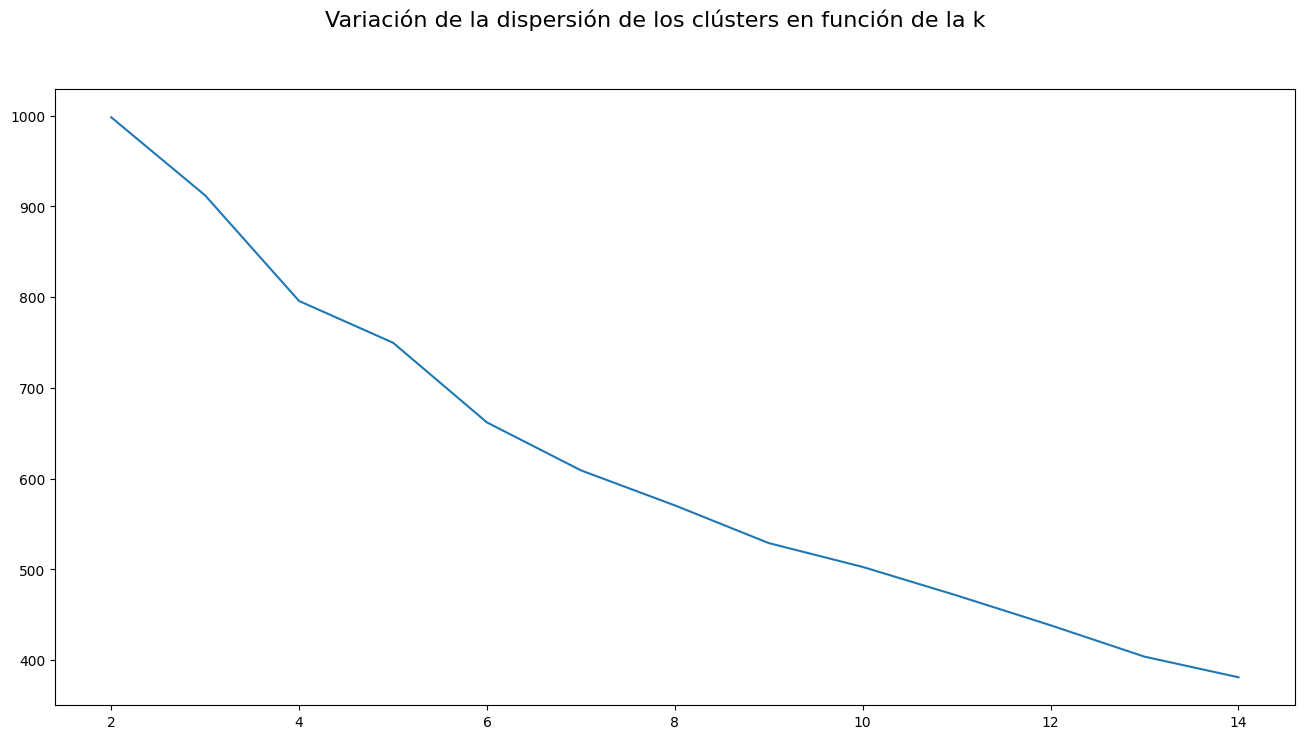

In [50]:
dibujar_curva_codo(df_final)

Elegimos 7 agrupaciones

## 4.2 Dibujamos Clusters

In [51]:
Clusters, X_processed=dibujar_cluster(df_final,6)

In [52]:
Clusters.style.background_gradient(cmap = 'Blues', axis = 1)

## 4.3 Cluster final

In [53]:
ficha_df = montar_tabla_cluster(df_final,X_processed)

In [54]:
ficha_df = ficha_df.rename(columns = {
    0 : "Más caros",
    1 : "No estacionales",
    2 : "Estacionales",
    3 : "Vendidos en eventos",
    4 : "Estrella",
    5 : "Al alza"
})

In [55]:
ficha_df.style.background_gradient(cmap = 'Blues', axis = 1)

In [56]:
X_processed.head()

,vendidos_tot_item,precio_min_item,precio_max_item,income_med_item,med_dias_entre_ventas,tendencia_item,estacionalidad_item,events_med_item,cluster
item,,,,,,,,,
0,4093.0,6.650,12.741,15.31,1.04,0.0,0.0,1.18,1
1,5059.0,2.660,5.280,6.73,1.16,0.0,0.0,1.24,1
2,1435.0,1.250,3.950,4.81,1.35,0.0,1.0,1.23,2
3,39175.0,5.014,6.171,19.90,1.01,0.0,1.0,1.17,2
4,14621.0,2.647,4.096,7.18,1.03,0.0,1.0,1.18,2


# 5 Exportación

## 5.1 Borramos las columnas que no nos sirven para la tabla de clusters, solo necesitamos el id_item y el cluster.

In [57]:
X_processed=X_processed.drop(columns=['vendidos_tot_item'])
X_processed=X_processed.drop(columns=['precio_min_item'])
X_processed=X_processed.drop(columns=['income_med_item'])
X_processed=X_processed.drop(columns=['med_dias_entre_ventas'])
X_processed=X_processed.drop(columns=['tendencia_item'])
X_processed=X_processed.drop(columns=['estacionalidad_item'])
X_processed=X_processed.drop(columns=['precio_max_item'])
X_processed=X_processed.drop(columns=['events_med_item'])

In [58]:
X_processed.head()

,cluster
item,
0,1
1,1
2,2
3,2
4,2


In [59]:
X_processed.reset_index(inplace=True)

In [60]:
X_processed=X_processed.rename(columns={'item':'id_item'})

## 5.2 Definimos los descriptivos

In [61]:
def asignar_texto(valor):
    if valor == 0:
        return 'Más caros'
    elif valor == 1:
        return 'No estacionales'
    elif valor == 2:
        return 'Estacionales'
    elif valor == 3:
        return 'Más Vendidos en eventos'
    elif valor == 4:
        return 'Estrella'
    elif valor == 5:
        return 'Al alza'
    

In [62]:
X_processed['nombre cluster'] = X_processed['cluster'].apply(asignar_texto)

In [63]:
X_processed.head()

,id_item,cluster,nombre cluster
0,0,1,No estacionales
1,1,1,No estacionales
2,2,2,Estacionales
3,3,2,Estacionales
4,4,2,Estacionales


## 5.3 Exportación datos

In [64]:
filepath = Path(direccion+"DIM_CLUSTER.csv")
X_processed.to_csv(filepath,index=False)